## Analyze Trackmate Tracks
The following code computes:
 * Velocities distribuition directly from spot displacements
 * Velocitiy distribution from fitting mean-squared-displacement (MSD) curves individually 
 * Average velocity from fitting a mean MSD curve
 * Directionality from velocity auto-correlation analysis

and saves all figures and data as pdf and xlsx

### Analyze TrackMate XML File 
 * Select a TrackMate XML File ( e.g  "path / filename.xml " )
 * Plots the output of each analysis and saves figs (pdf) & data (excel)


Physical units: micron, sec.
Number of tracks: 750
Frame interval: 2.0 

Processing Velocities Distribution ...
Processing Single Track MSD Analysis ...
Processing Averaged MSD Analysis ...
Processing Velocity Autocorrelation ...


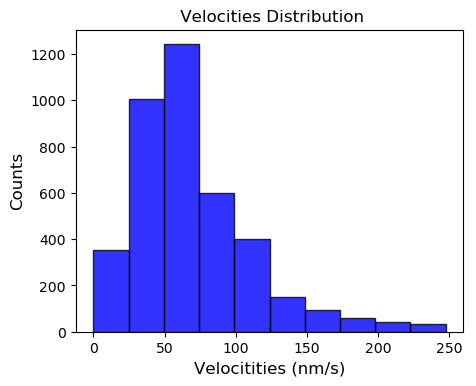

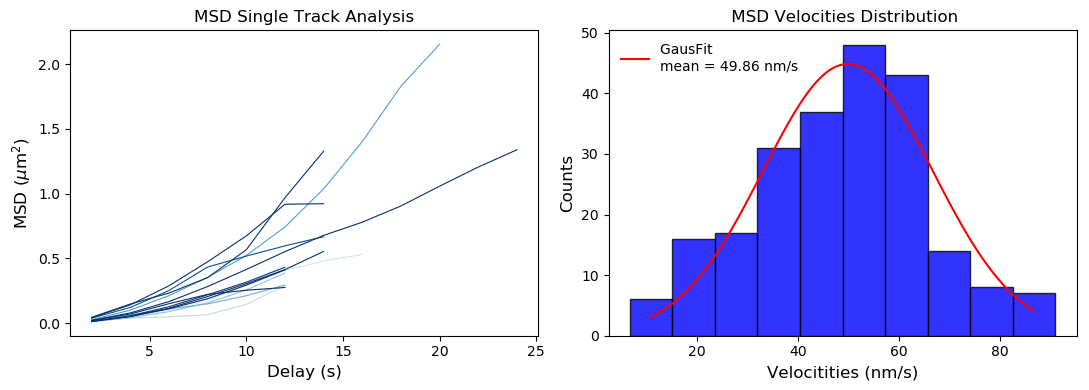

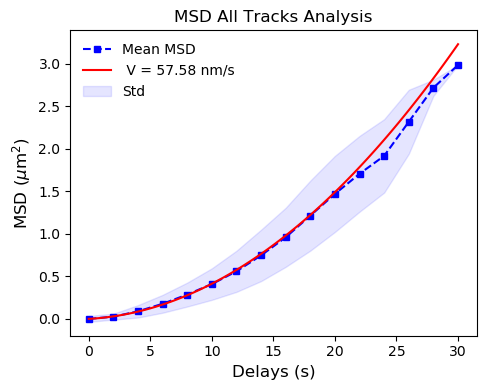

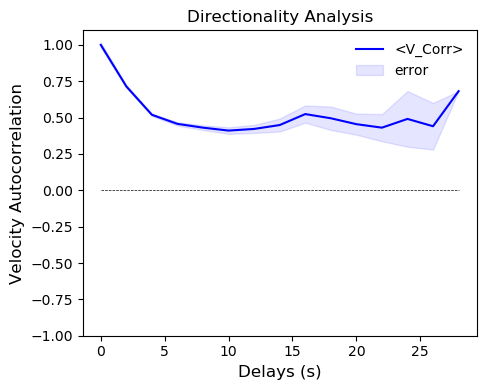

Done!


In [5]:
# import modules for analysis
from analyze_tracks import read, msd, velocity, utils, process
%matplotlib inline

filename = 'C:/Users/pcaldas/Desktop/Data Analysis/Github/examples/ZapA_speckles_growth_Tracks.xml'
process.analyze_tracks(filename, clip = 0.5, plot_every = 20)

### In Batch Analysis
 * Select a folder containing TrackMate XML Files
 * Saves all figs (pdf) all data (excel)

Processing ZapC 0.5uM + ZapA 3uM 2019.01.29 (p#39.1)_growth_Tracks.xml


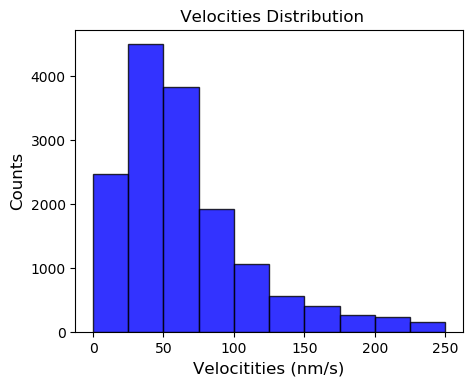

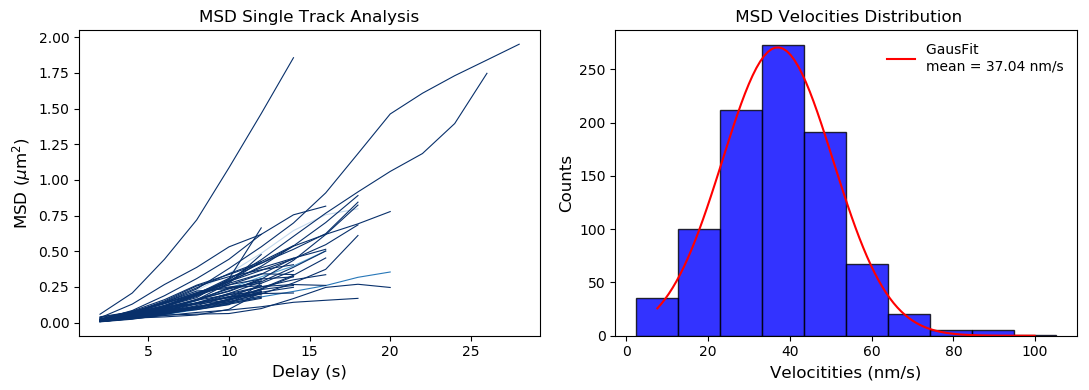

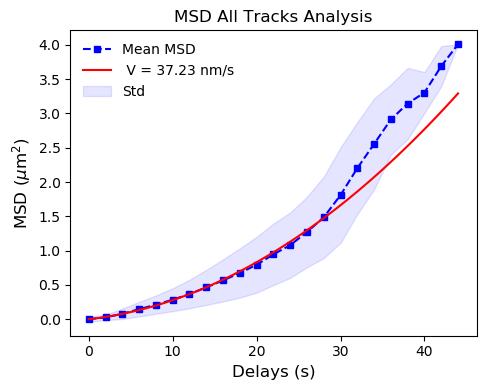

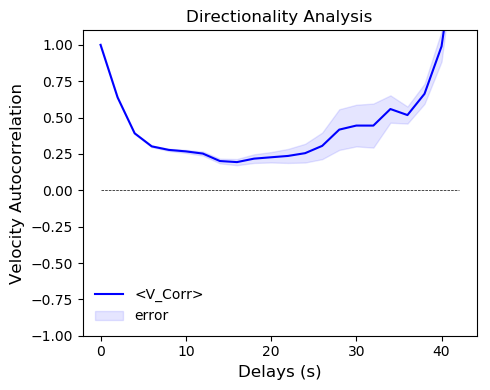

Processing ZapC 0.5uM + ZapA 3uM 2019.01.30 (p#41.1)_growth_Tracks.xml


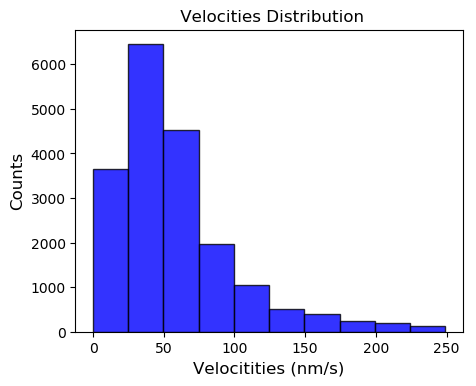

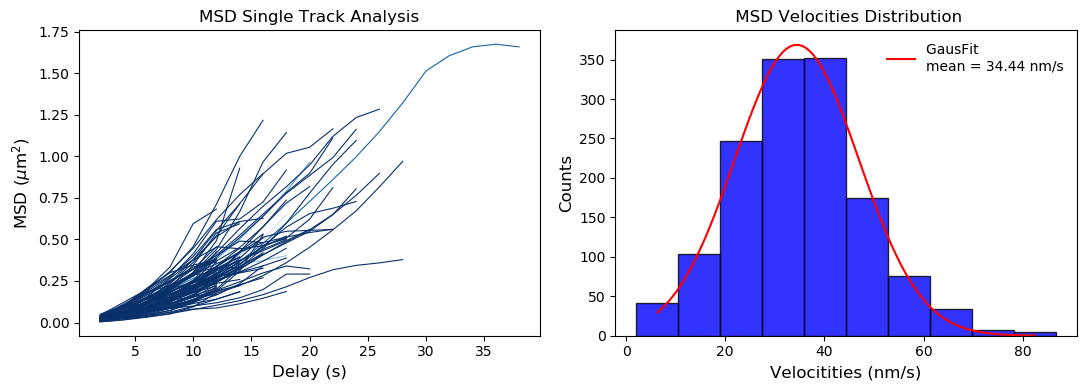

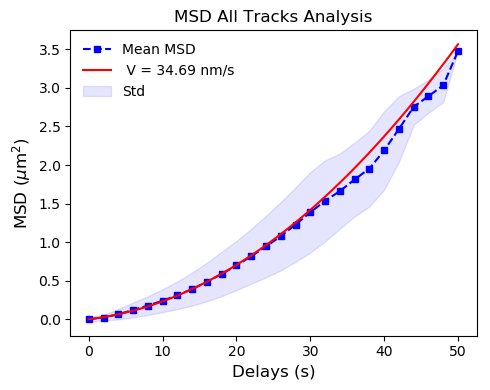

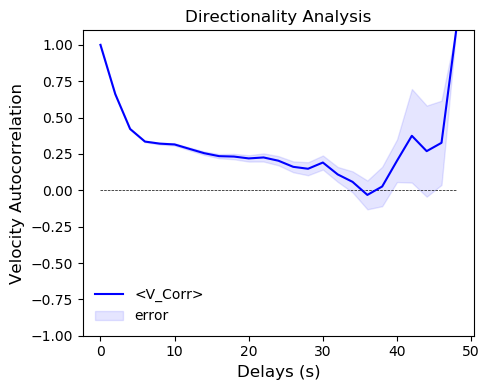

Processing ZapC 0.5uM + ZapA 3uM 2019.01.31 (p#50.1)_growth_Tracks.xml


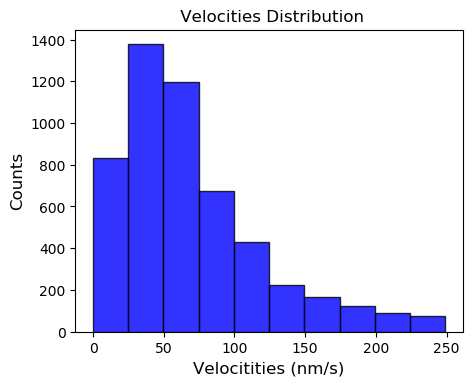

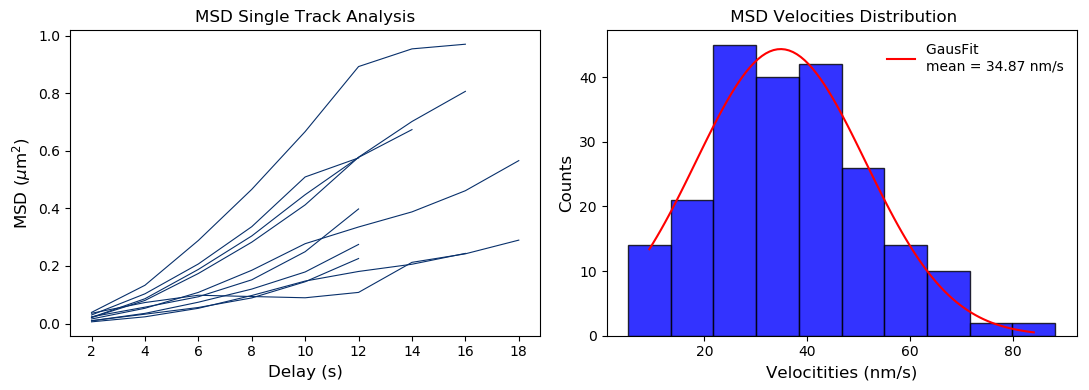

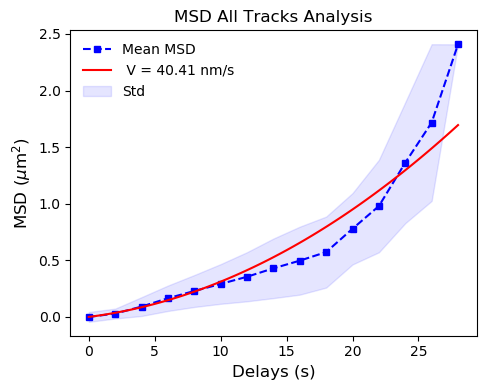

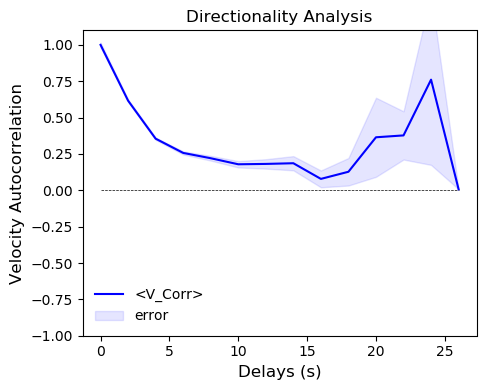

Processing ZapC 0.5uM +ZapA 3uM 2019.01.31 (p#48.1)_growth_Tracks.xml


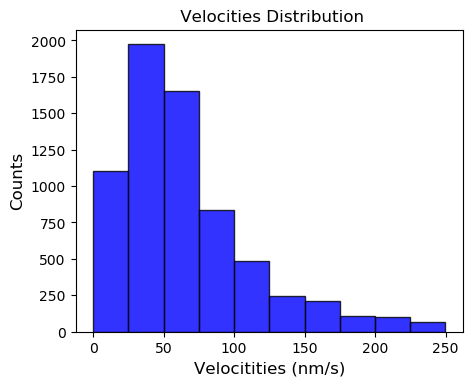

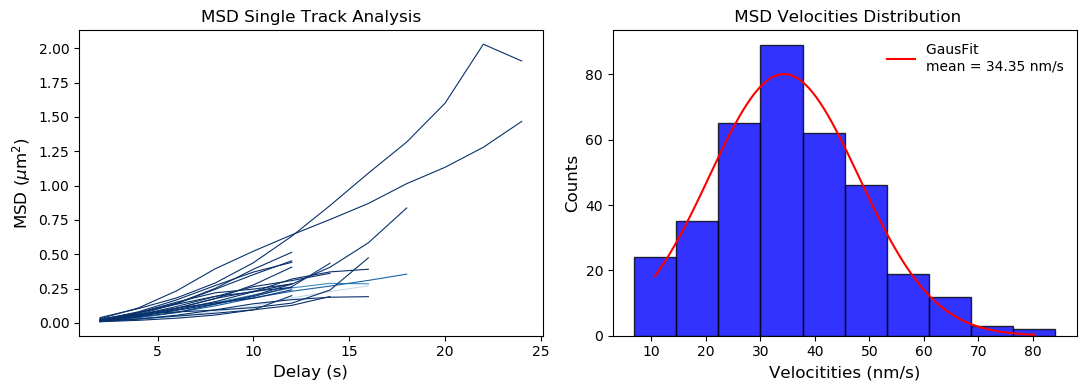

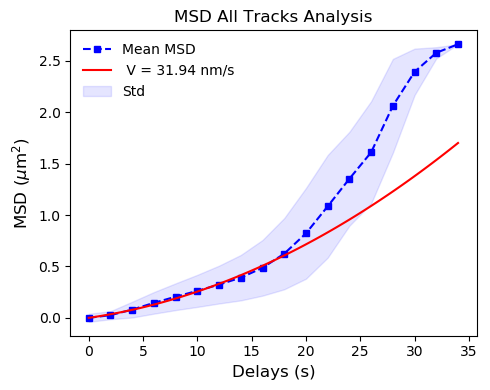

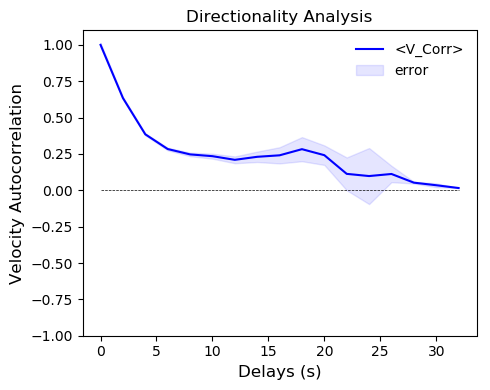

Processing ZapC 1uM + ZapA 0.5uM 2019.02.05 (p#60)_growth_Tracks.xml


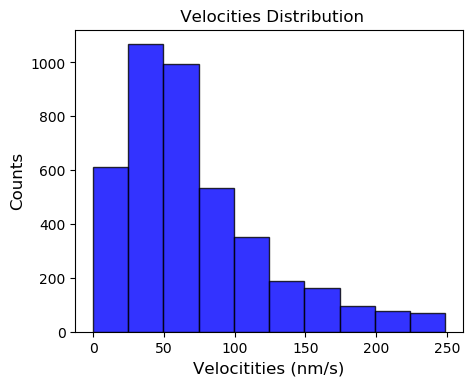

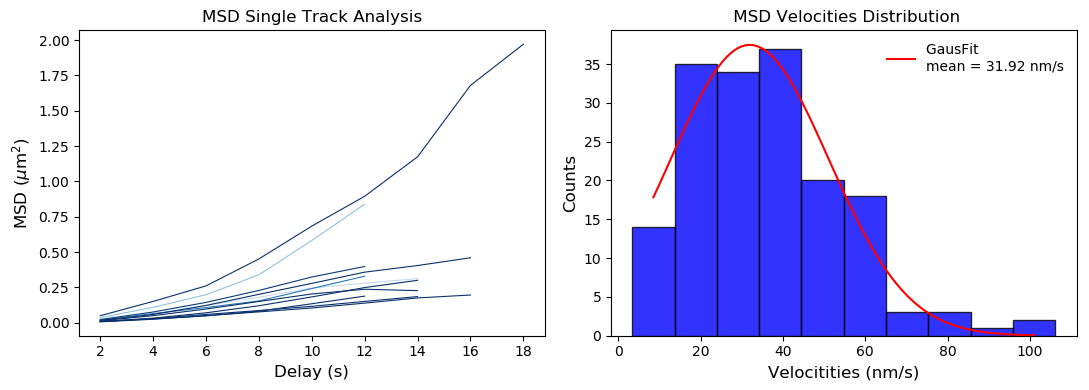

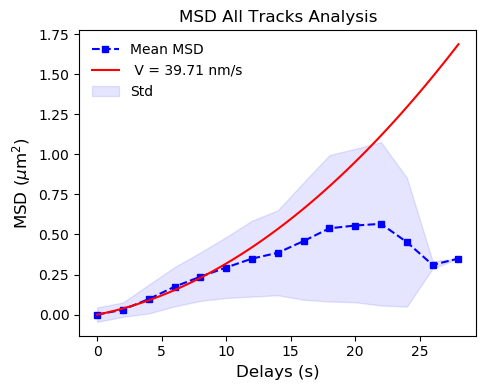

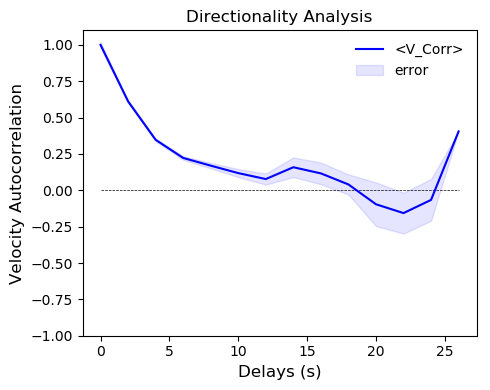

Processing ZapC 1uM + ZapA 0.5uM 2019.02.05 (p#62.1)_growth_Tracks.xml


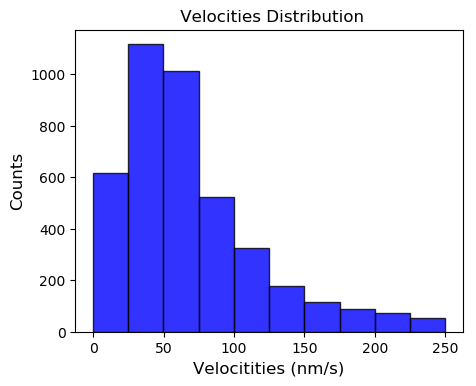

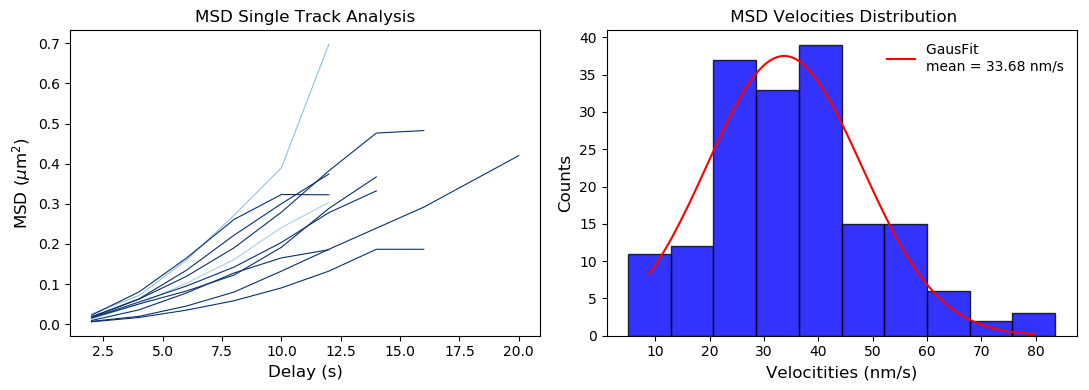

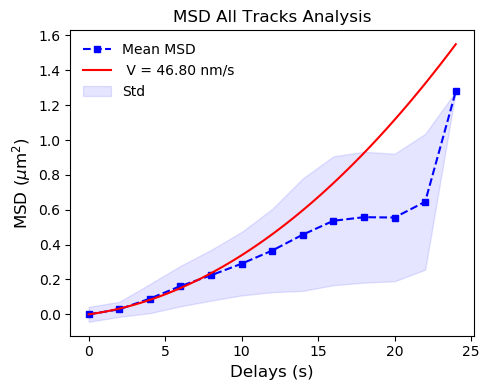

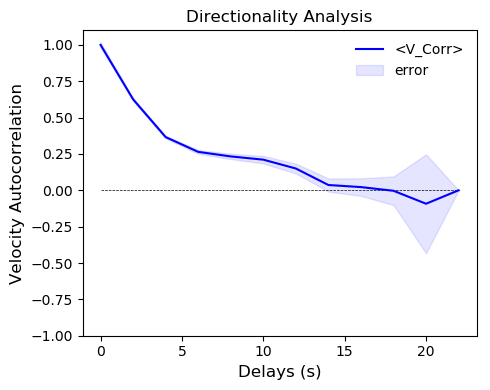

Processing ZapC 1uM + ZapA 3uM 2019.01.29 (p#37.1)_growth_Tracks.xml


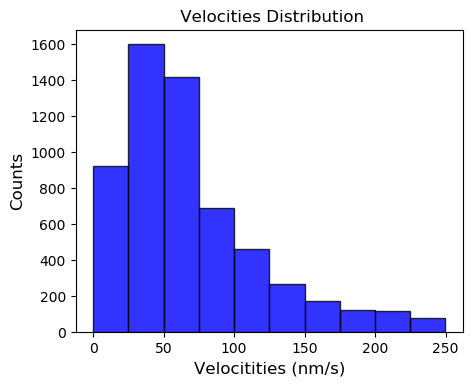

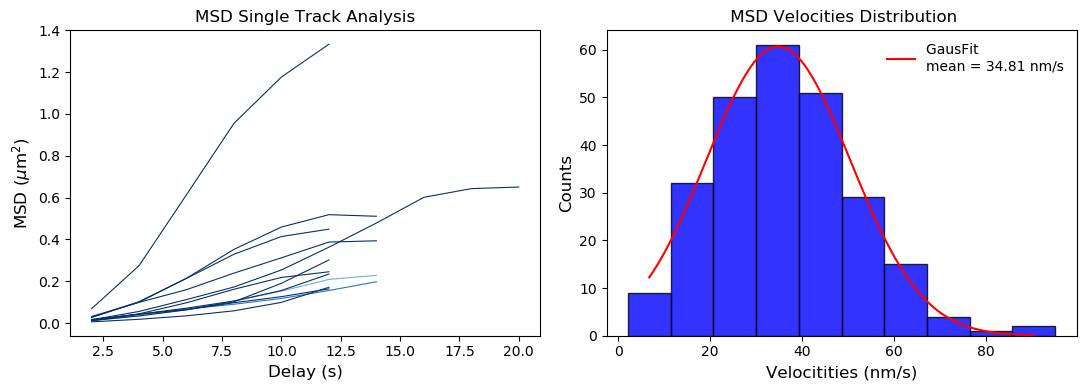

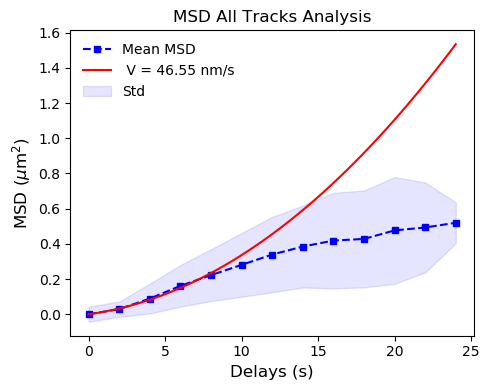

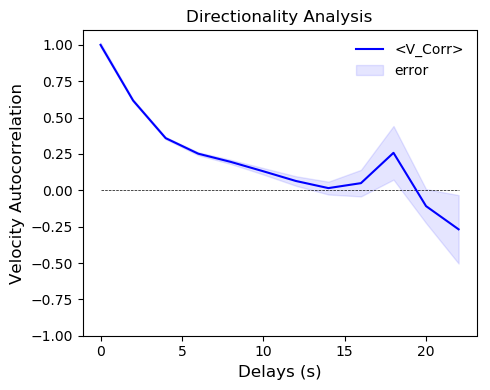

Processing ZapC 1uM + ZapA 3uM 2019.01.30 (p#42.1)_growth_Tracks.xml


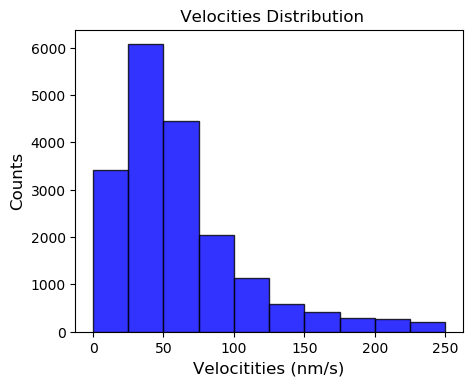

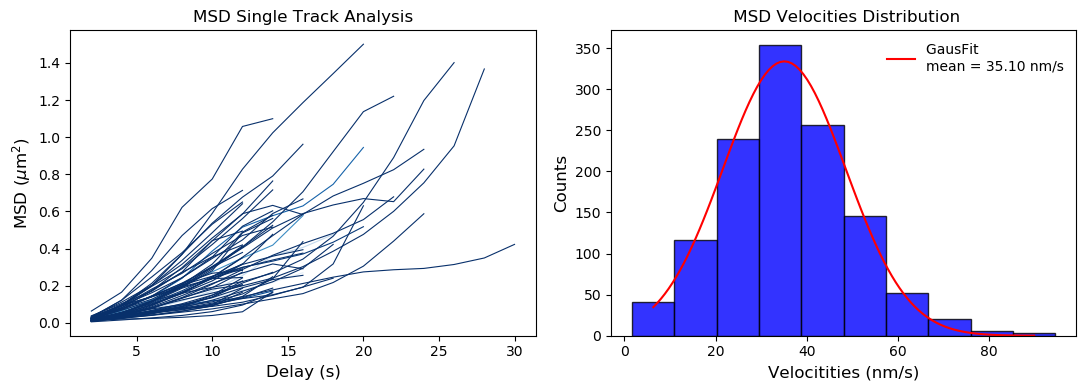

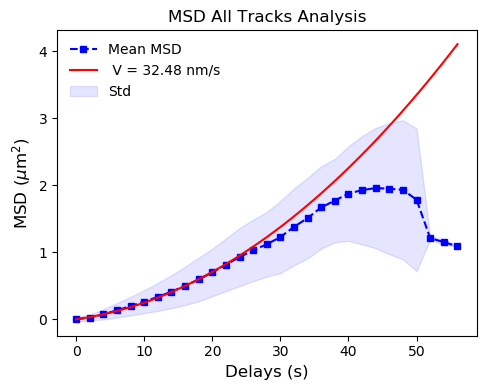

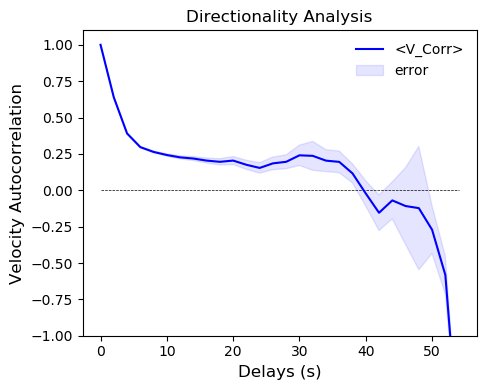

Processing ZapC 1uM + ZapA 3uM 2019.01.30 (p#43.1)_growth_Tracks.xml


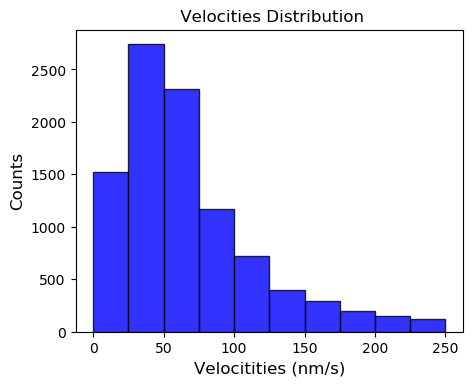

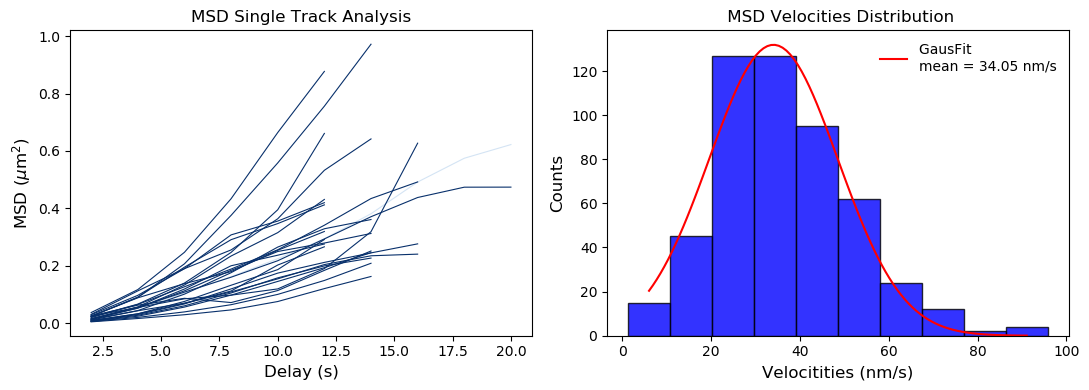

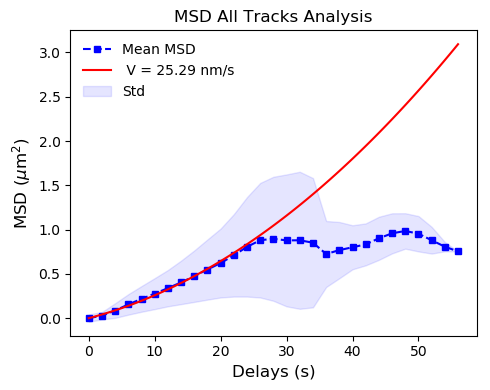

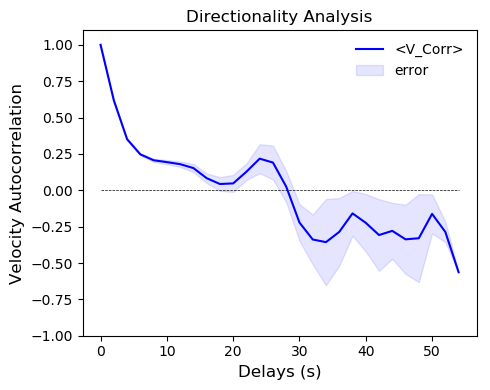

Processing ZapC 1uM + ZapA 3uM 2019.01.31 (p#46.1)_growth_Tracks.xml


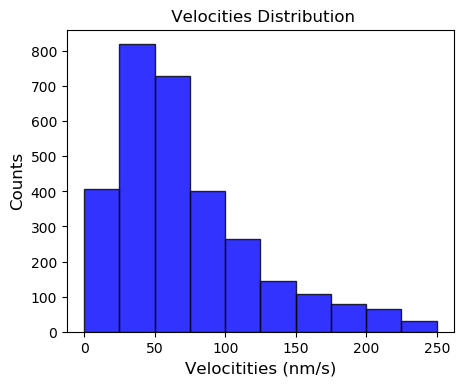

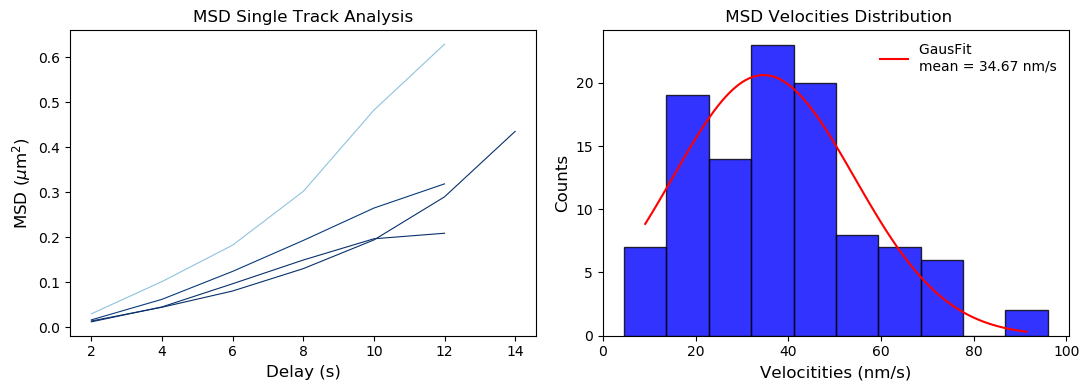

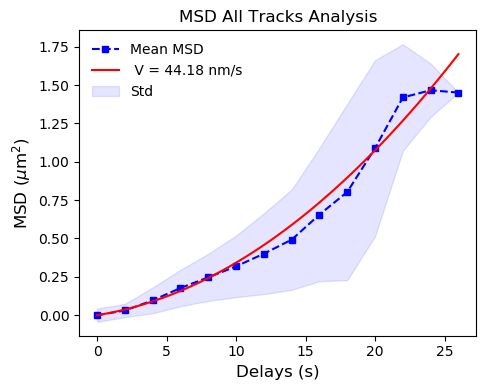

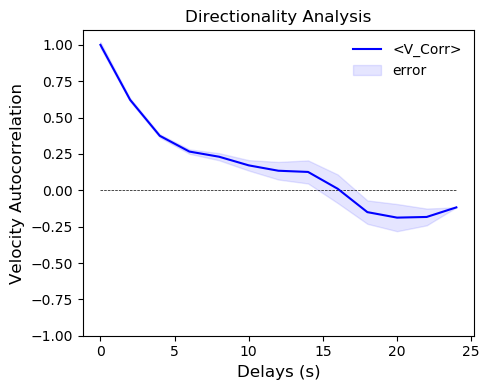

Processing ZapC 1uM + ZapA 3uM 2019.01.31 (p#47.1)_growth_Tracks.xml


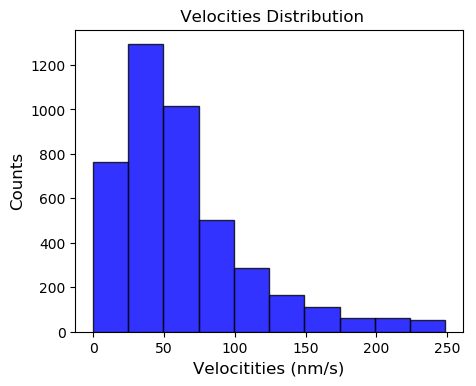

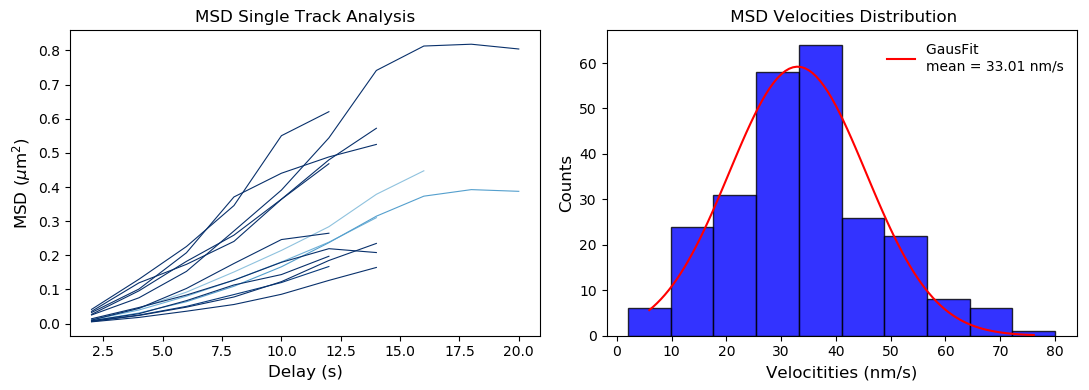

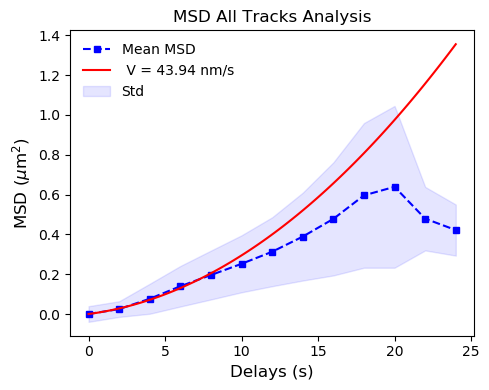

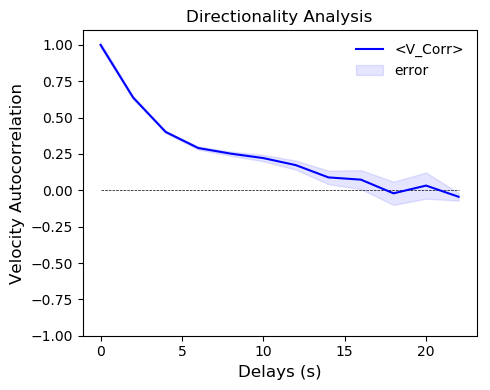

Processing ZapC 1uM + ZapA 3uM 2019.01.31 (p#49.1)_growth_Tracks.xml


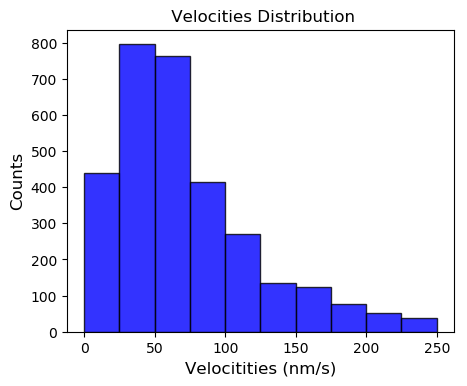

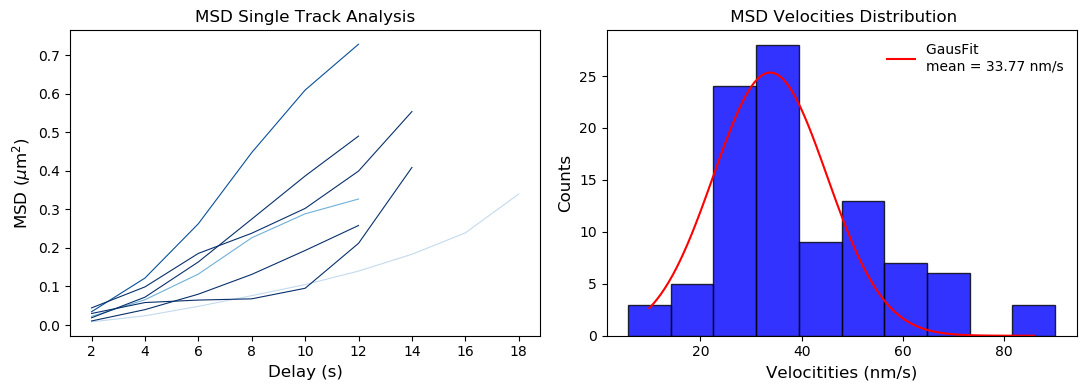

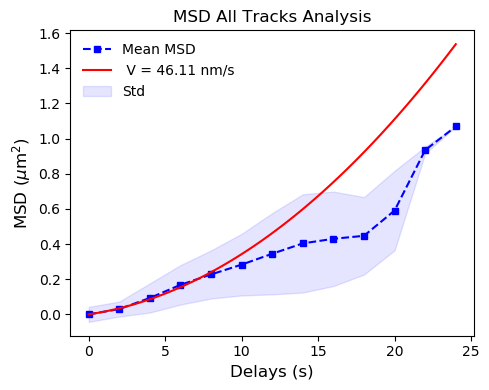

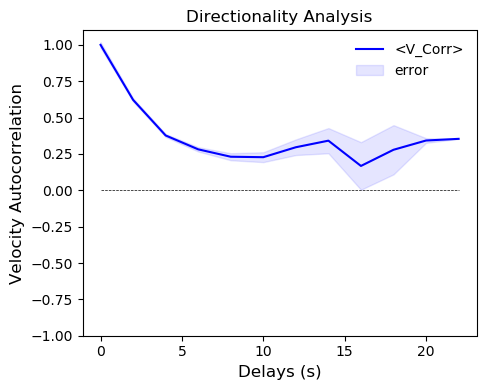



Done!


In [2]:
# import modules for analysis
from analyze_tracks import read, msd, velocity, utils, process

#folder containning xml files to analyze
files_dir = "C:/Users/pcaldas/Desktop/Data Analysis/Zaps Data Analysis/ZapC and ZapD/Treadmilling Analysis/ZapC + ZapA data"

process.analyze_tracks_batch(files_dir, clip = 0.5)